In [229]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings("ignore")

seed = 42
torch.manual_seed(seed)

In [230]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [231]:
X_train = train_dataset.train_data.view(-1, 28*28).float()/255.00
y_train = train_dataset.train_labels
X_test = test_dataset.test_data.view(-1, 28*28).float()/255.00
y_test = test_dataset.test_labels
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([60000, 784]),
 torch.Size([60000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [232]:
shuffle_index = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffle_index].T, y_train[shuffle_index]
X_test, y_test = X_test.T, y_test
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([784, 60000]),
 torch.Size([60000]),
 torch.Size([784, 10000]),
 torch.Size([10000]))

In [233]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        v = out
        out = self.fc3(out)
        return out, v

In [234]:
model = MLP(28*28, 30, 20, 10)

In [235]:
_, v = model(X_train[:,:1000].T)
v = v.detach().numpy()
v.shape

(1000, 20)

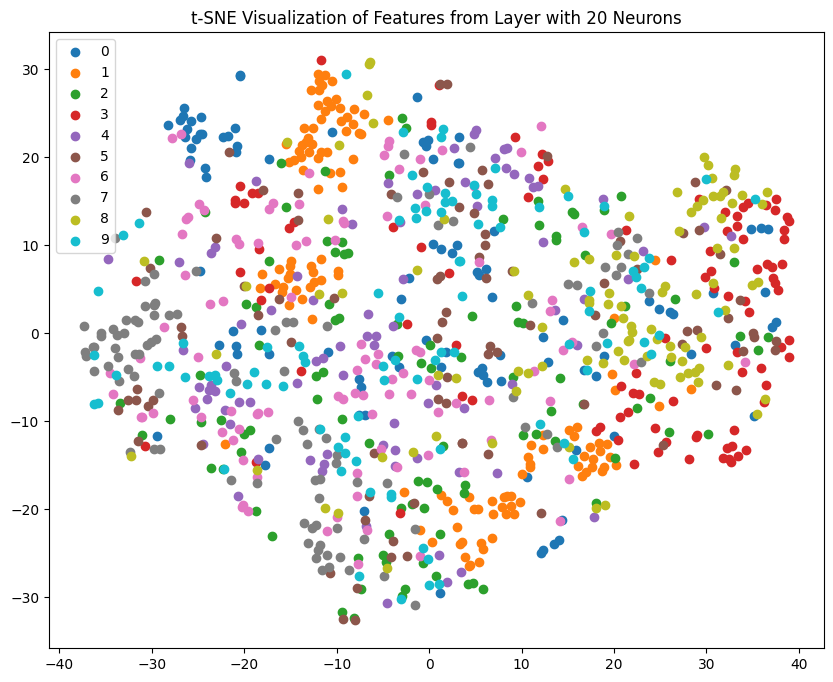

In [236]:
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(v)

plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(tsne_features[y_train[:1000] == i, 0], tsne_features[y_train[:1000] == i, 1], label=str(i))
plt.title('t-SNE Visualization of Features from Layer with 20 Neurons')
plt.legend()
plt.show()

In [237]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100
batch_size = 64

In [238]:
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        X = X_train[:, i:i+batch_size]
        y = y_train[i:i+batch_size]
        outputs, _ = model(X.T)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch%10 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(X_train), loss.item()))

Epoch [1/100], Step [769/784], Loss: 1.1893
Epoch [11/100], Step [769/784], Loss: 0.0774
Epoch [21/100], Step [769/784], Loss: 0.0036
Epoch [31/100], Step [769/784], Loss: 0.0016
Epoch [41/100], Step [769/784], Loss: 0.0010
Epoch [51/100], Step [769/784], Loss: 0.0006
Epoch [61/100], Step [769/784], Loss: 0.0005
Epoch [71/100], Step [769/784], Loss: 0.0003
Epoch [81/100], Step [769/784], Loss: 0.0003
Epoch [91/100], Step [769/784], Loss: 0.0002


In [239]:
preds, _ = model(X_test.T)
_, predicted = torch.max(preds, 1)

In [240]:
accuracy = accuracy_score(y_test, predicted)
f1_score = f1_score(y_test, predicted, average='weighted')
print('Accuracy using MLP: {:.2f}%'.format(accuracy*100))
print('F1 Score using MLP: {:.2f}'.format(f1_score))

Accuracy using MLP: 87.75%
F1 Score using MLP: 0.88


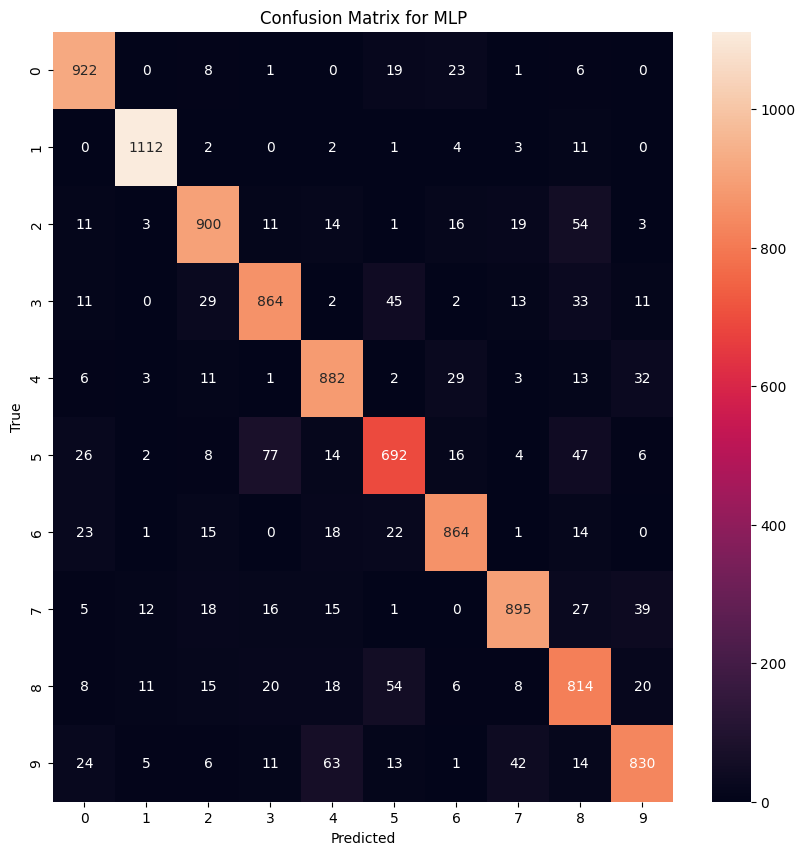

In [241]:
cm = confusion_matrix(y_test, predicted)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix for MLP')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

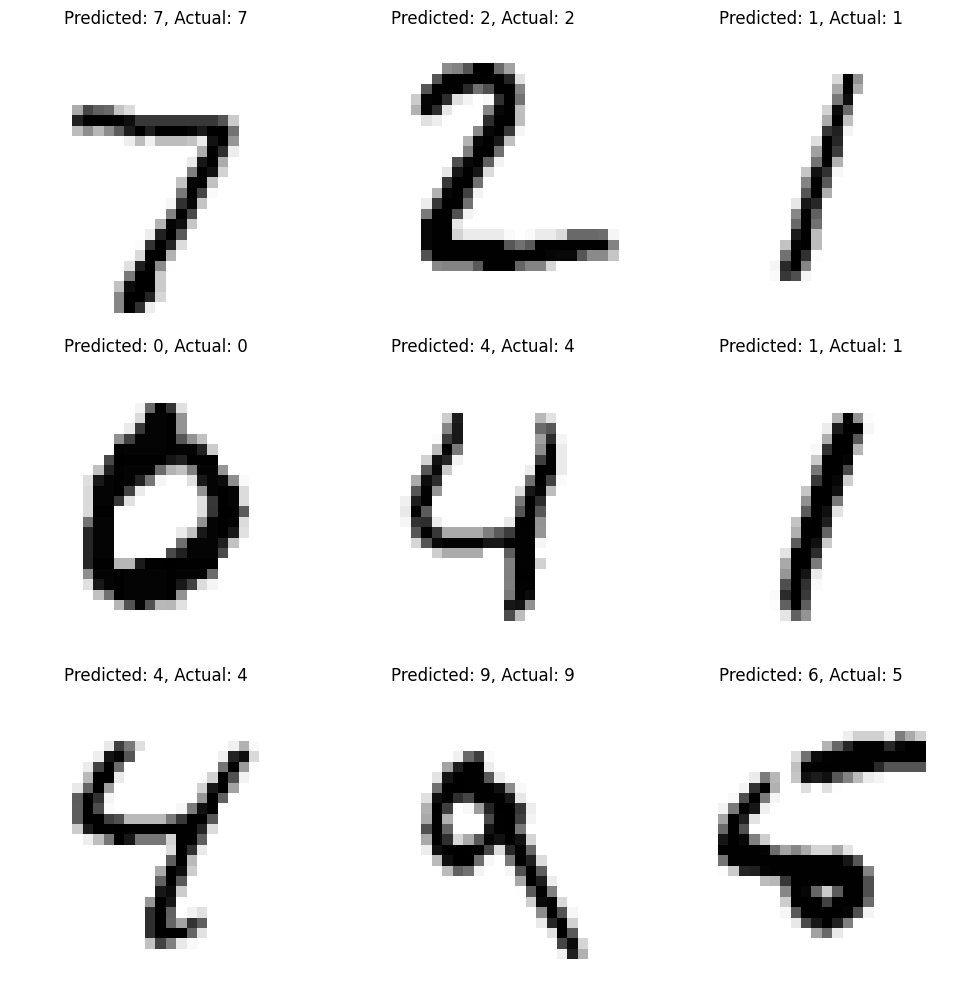

In [242]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[:, i].reshape(28, 28), cmap='binary')
    ax.set_title('Predicted: {}, Actual: {}'.format(predicted[i], y_test[i]))
    ax.axis('off')
plt.tight_layout()
plt.show()

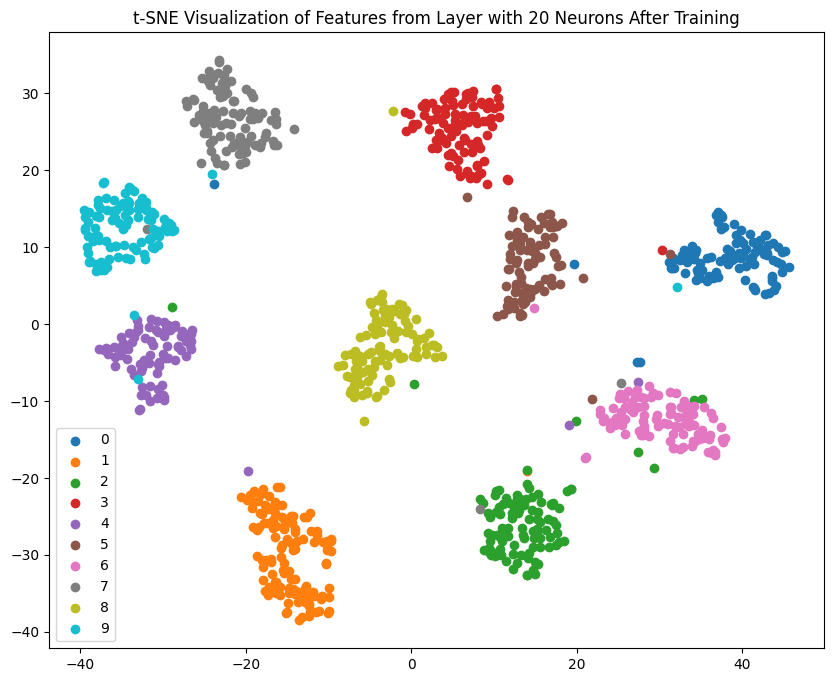

In [243]:
_, v = model(X_train[:,:1000].T)
v = v.detach().numpy()

tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(v)

plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(tsne_features[y_train[:1000] == i, 0], tsne_features[y_train[:1000] == i, 1], label=str(i))
plt.title('t-SNE Visualization of Features from Layer with 20 Neurons After Training')
plt.legend()
plt.show()

Here we can clearly see that after training our model is able to clearly cluster the images containing same number.

In [244]:
X_train = X_train.numpy()
X_test = X_test.numpy()
y_train = y_train.numpy()
y_test = y_test.numpy()

In [245]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train.T, y_train)

LogisticRegression(random_state=42)

In [246]:
preds = log_reg.predict(X_test.T)
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, preds)*100))
print('F1 Score: {:.2f}'.format(f1_score(y_test, preds, average='weighted')))

Accuracy: 92.56%


TypeError: 'numpy.float64' object is not callable

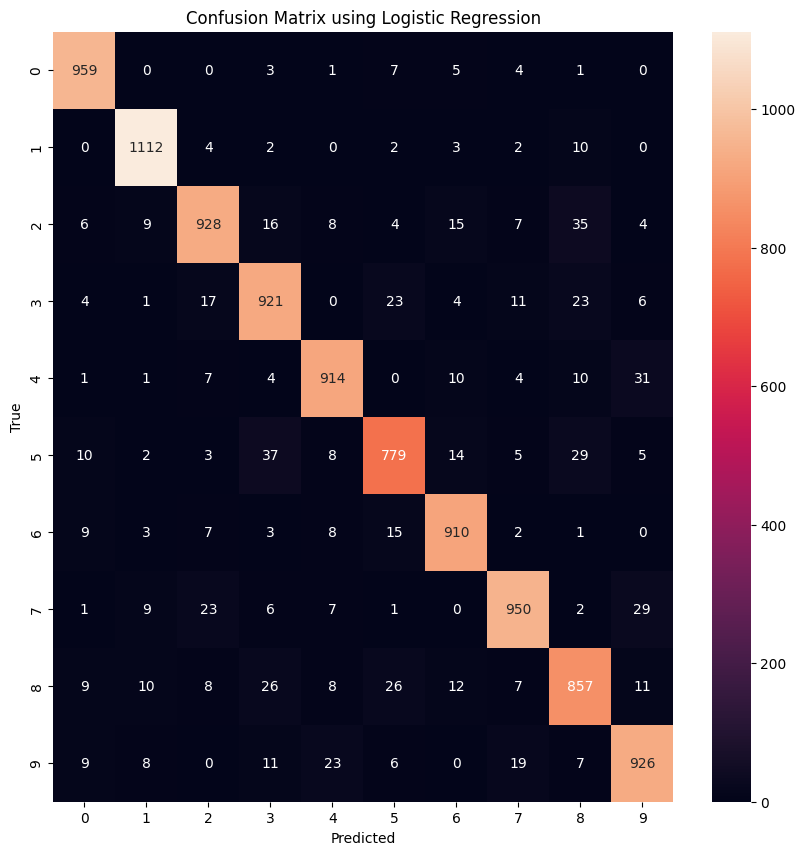

In [ ]:
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix using Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train.T, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
preds = rf.predict(X_test.T)
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, preds)*100))
print('F1 Score: {:.2f}'.format(f1_score(y_test, preds, average='weighted')))

Accuracy: 96.91%
F1 Score: 0.97


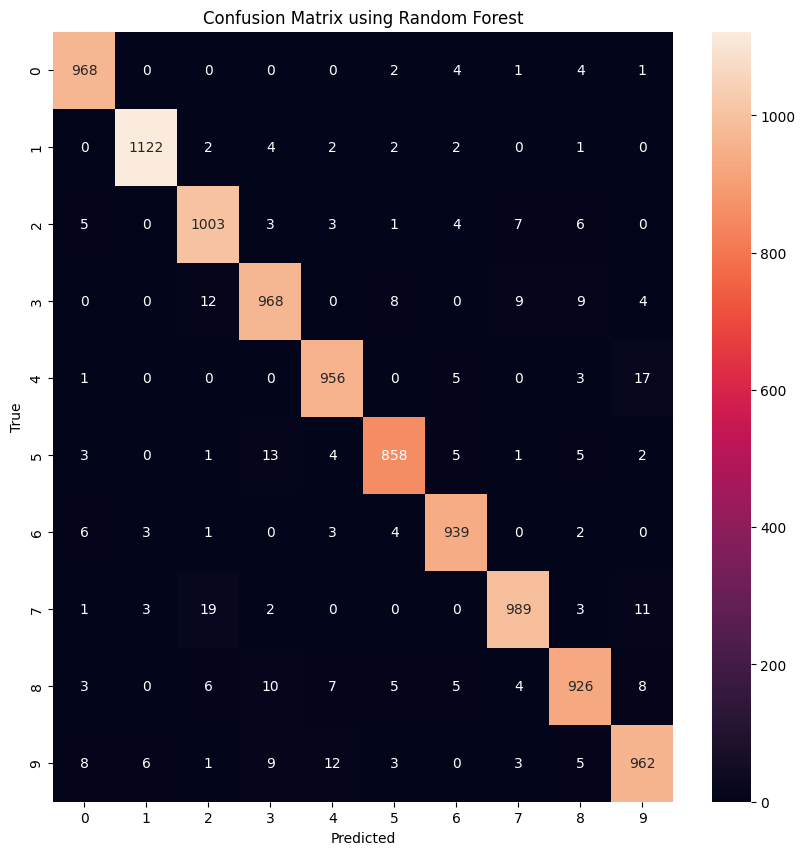

In [ ]:
cn = confusion_matrix(y_test, preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cn, annot=True, fmt="d")
plt.title('Confusion Matrix using Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Here we can see that accross all models the digit 9 is often confused with digits 4 and 7, this may be due to them actually looking very similar which the model cannot judge correctly.

In [255]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [256]:
X_train = train_dataset.train_data.view(-1, 28*28).float()/255.00
y_train = train_dataset.train_labels
X_test = test_dataset.test_data.view(-1, 28*28).float()/255.00
y_test = test_dataset.test_labels
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([60000, 784]),
 torch.Size([60000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [257]:
shuffle_index = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffle_index].T, y_train[shuffle_index]
X_test, y_test = X_test.T, y_test

In [258]:
preds, _ = model(X_test.T)
_, predicted = torch.max(preds, 1)

In [260]:
print('Accuracy using MLP: {:.2f}%'.format(accuracy_score(y_test, predicted)*100))

Accuracy using MLP: 9.71%


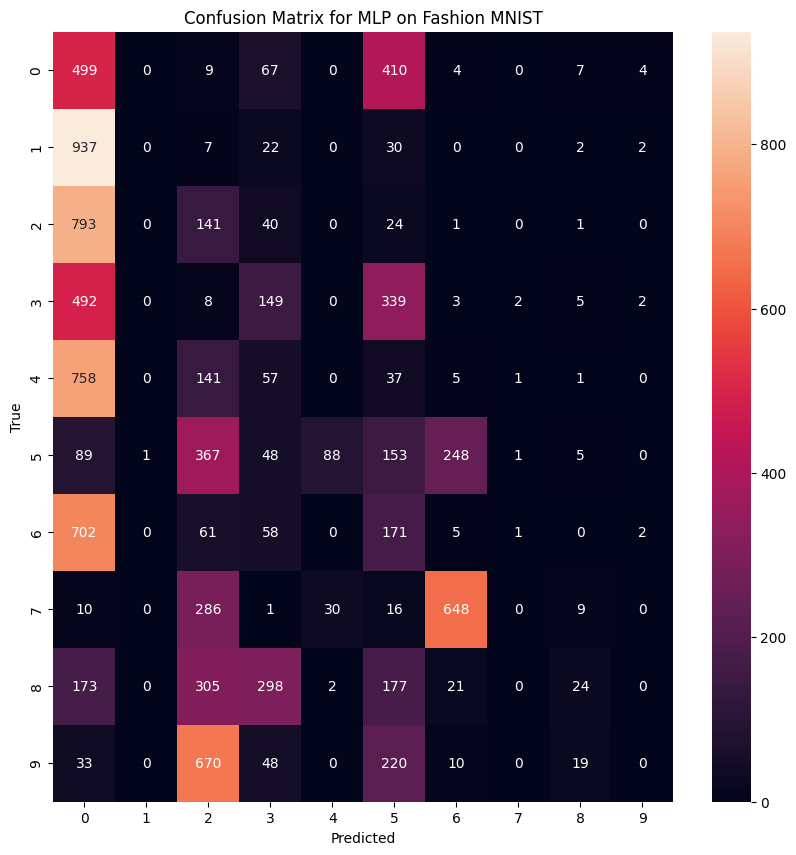

In [261]:
cn = confusion_matrix(y_test, predicted)
plt.figure(figsize=(10, 10))
sns.heatmap(cn, annot=True, fmt="d")
plt.title('Confusion Matrix for MLP on Fashion MNIST')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

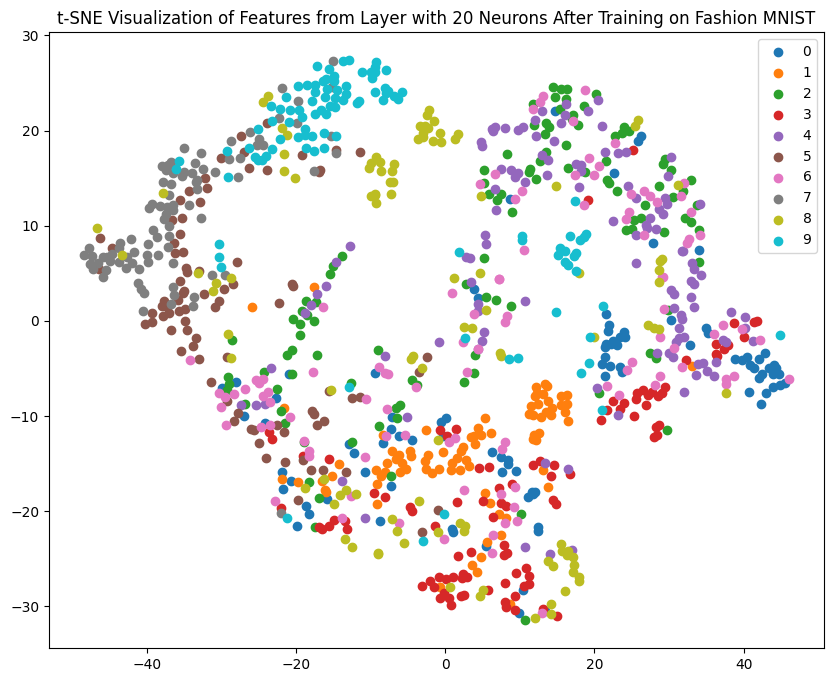

In [262]:
_, v =  model(X_train[:,:1000].T)
v = v.detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(v)

plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(tsne_features[y_train[:1000] == i, 0], tsne_features[y_train[:1000] == i, 1], label=str(i))
plt.title('t-SNE Visualization of Features from Layer with 20 Neurons After Training on Fashion MNIST')
plt.legend()
plt.show()

Here we can clearly see that no proper clustering is being done by the model as it was not trained on the given dataset.